# Numpy实现逻辑回归 - 识别猫

在该实验中我们将介绍如何使用Python及Numpy lib库实现Logistic回归模型来识别猫。在实现过程中，读者将会学习到神经网络基本结构的配置，其中的关键知识点包括初始化参数、计算成本、计算梯度、优化参数。需要注意的是，在具体的编码实现中会大量是用到Numpy lib库的基本操作，不熟悉numpy操作的读者可以回顾numpy操作内容，方便后续的学习。下面就进入编程实战部分。

** 图片处理 **

由于识别猫问题涉及到图片处理指示，这里对计算机如何保存图片做一个简单的介绍。在计算机中，图片被存储为三个独立的矩阵，分别对应图3-6中的红、绿、蓝三个颜色通道，如果图片是64*64像素的，就会有三个64*64大小的矩阵，要把这些像素值放进一个特征向量中，需要定义一个特征向量X，将三个颜色通道中的所有像素值都列出来。如果图片是64*64大小的，那么特征向量X的总纬度就是64*64*3，也就是12288维。这样一个12288维矩阵就是Logistic回归模型的一个训练数据。

<img src="images/image_to_vector.png" style="width:550px;height:300px;">

## 1 - 引用库

首先，载入几个需要用到的库，它们分别是：
- numpy：一个python的基本库，用于科学计算
- matplotlib.pyplot：用于生成图，在验证模型准确率和展示成本变化趋势时会使用到
- lr_utils：定义了load_dataset()方法用于载入数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lr_utils import load_dataset

## 2 - 	载入数据

猫的图片数据集以hdf5文件的形式存储，包含了如下内容：

- 训练数据集：包含了m_train个图片的数据集，数据的标签（Label）分为cat（y=1）和non-cat（y=0）两类。

- 测试数据集：包含了m_test个图片的数据集，数据的标签（Label）同（1）。

单个图片数据的存储形式为（num_x, num_x, 3），其中num_x表示图片的长或宽（数据集图片的长和宽相同），数字3表示图片的三通道（RGB）。

在代码中使用一行代码来读取数据，我们暂不需要了解数据的读取过程，只需调用load_dataset()方法，并存储五个返回值，以便后续的使用。

需要注意的是，添加“_orig”后缀表示该数据为原始数据，因为之后还需要对数据进行进一步处理。未添加“_orig”的数据则表示之后不对该数据作进一步处理。


In [2]:
# 读取数据(cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

上述数据共包含五个部分，分别是训练和测试数据集train_set_x_orig、test_set_x_orig以及对应的标签集train_set_y，test_set_y，还有一个分类列表classes。以训练数据集train_set_x_orig为例，其中每一行都是一个表示图像的三维数组。

## 3 - 数据预处理

获取数据后的下一步工作是获得数据的相关信息，如训练数据个数m_train、测试数据个数m_test和图片的长度或宽度num_x，下述代码使用numpy.array.shape来获取数据的相关信息。

In [3]:
# 获取数据相关信息
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
# 本例中num_px=64
num_px = train_set_x_orig.shape[1]

接下来需要对数据作进一步处理，为了便于训练，可以忽略图片的结构信息，将包含图像长、宽和通道数信息的三维数组压缩成一维数组，图片数据的形状将由(64, 64, 3)转化为(64 * 64 * 3, 1)，代码清单3-7给出了转换数据形状的方式。

In [4]:
# 转换数据形状
train_set_x_flatten = train_set_x_orig.reshape(m_train,-1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test,-1).T

在开始训练之前，还需要对数据进行归一化处理。图片采用红、绿、蓝三通道的方式来表示颜色，每个通道的单个像素点都存储着一个0-255的像素值，所以图片的归一化处理十分简单，只需要将数据集中的每个值除以255即可，但需要注意的是结果值应为float类型，直接除以255会导致结果错误，在Python中除以255.即可将结果转化为float类型，下述代码给出了数据归一化过程。

In [5]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 4 - 模型训练

完成了数据处理工作，下面开始进入模型训练过程。其中有四个关键步骤分别为：
- 初始化模型参数（Parameters）
- 循环：
    - 计算成本（Cost）
    - 计算梯度（Gradient）
    - 更新参数（Gradient Descent）
- 利用模型进行预测
- 分析预测结果

首先，实现Sigmoid()激活函数如下代码所示，较为简单，不再赘述：

In [6]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

接下来开始初始化模型参数，定义函数initialize_with_zeros()如代码所示，首先使用numpy.zeros()将w初始化为(dim, 1)形状的零向量，其中dim表示w参数的个数，它的值等于训练数据的特征数，即每张图片的像素点个数。然后再将b初始化为0即可。

In [7]:
def initialize_with_zeros(dim):
    # 将w初始化为(dim, 1)形状的零向量，其中dim表示w参数个数
    # 将b初始化为零
    w = np.zeros((dim, 1), dtype = np.float)
    b = 0
    
    return w, b

初始化模型参数后，接下来定义前向播和后向传播过程，这两个过程包含在 propagate()函数中。

函数propagate()的关键内容是计算成本函数（Cost）和梯度（Gradient），具体的实现如下述代码所示，其中m=X.shape[1]表示数据个数，A表示预测结果，cost表示成本函数，dw和db分别表示对应的梯度。

In [8]:
def propagate(w, b, X, Y):
    """
    计算成本cost和梯度grads
        Args:
            w -- 权重， (num_px * num_px * 3, 1)维的numpy数组
            b -- 偏置bias，标量
            X -- 数据，形状为(num_px * num_px * 3, number of examples)
            Y -- 数据的真实标签(包含值 0 if non-cat, 1 if cat) ，形状为 (1, number of examples)
        Return:
            cost -- 逻辑回归的损失函数
            dw -- cost对参数w的梯度，形状与参数w一致
            db -- cost对参数b的梯度，形状与参数b一致
    """
    
    # m为数据个数
    m = X.shape[1]
    
    # 前向传播，计算成本函数
    A = sigmoid(np.dot(w.T,  X) + b)                                    
    cost = np.sum(-(Y * np.log(A) + (1 - Y) * np.log(1 - A))) / m                                 
    
    # 后向传播，计算梯度
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum((A - Y)) / m
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


定义了成本函数和梯度的计算过程后，接下来定义优化函数optimize()使用梯度下降更新参数。具体实现如代码所示，关键内容为调用propagate()函数获取梯度值dw、db和cost，并根据梯度值来更新参数w和b。以w为例，具体更新过程为w -= learning_rate * dw。同时，在参数更新过程中，维护一个成本数组costs，每一百次迭代则记录一次成本，便于之后绘图分析成本变化趋势。

In [9]:
# 使用梯度下降更新参数w，b
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    使用梯度下降算法优化参数w和b
        Args:
            w -- 权重， (num_px * num_px * 3, 1)维的numpy数组
            b -- 偏置bias，标量
            X -- 数据，形状为(num_px * num_px * 3, number of examples)
            Y -- 数据的真实标签(包含值 0 if non-cat, 1 if cat) ，形状为 (1, number of examples)
            num_iterations -- 优化的迭代次数
            learning_rate -- 梯度下降的学习率，可控制收敛速度和效果
            print_cost -- 每一百次迭代输出一次cost
            
        Returns:
            params -- 包含参数w和b的python字典
            grads -- 包含梯度dw和db的python字典
            costs -- 保存了优化过程cost的list，可以用于输出cost变化曲线
        """

    costs = []
    
    for i in range(num_iterations):
        # 调用propagate()获取梯度值grads和成本cost
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        # 更新参数
        w -= learning_rate * dw 
        b -= learning_rate * db
        
        # 记录costs
        if i % 100 == 0:
            costs.append(cost)
        
        # 每一百次迭代，打印一次cost
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


## 5 - 模型检验

以上内容完成了模型的训练过程，得到了最终的参数w和b，接下来实现predict()函数使用训练完成的模型进行预测，具体实现如代码所示，输入参数w和b以及测试数据集X，预测结果A，并将连续值A转化为二分类结果0或1，存储在Y_prediction中。


In [10]:
# 使用模型进行预测
def predict(w, b, X):    
    """
    用学习到的逻辑回归模型来预测图片是否为猫（1 cat or 0 non-cat
        Args:
            w -- 权重， (num_px * num_px * 3, 1)维的numpy数组
            b -- 偏置bias，标量
            X -- 数据，形状为(num_px * num_px * 3, number of examples)
            
        Returns:
            Y_prediction -- 包含了对X数据集的所有预测结果，是一个numpy数组或向量
    """

    # m为数据个数
    m = X.shape[1]
    # 初始化Y_prediction为m维零向量
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    # 预测结果A
    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):
        # 将连续值A转化为二分类结果0或1
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    return Y_prediction


至此，上述内容完成了Logistic回归模型的训练和预测过程，实现了几个关键函数：
- sigmoid()：激活函数
- initialize_with_zeros()：初始化参数w和b
- propagate()：计算成本cost和梯度值dw、db
- optimize()：利用梯度下降更新参数值
- predict()：使用模型预测结果


## 6 - 实现model

现在进行最后一步，实现一个model()函数，将所有函数合并，实现过程十分简单，只需将上述函数按顺序调用即可，具体实现如代码所示，需要注意的是代码中计算了训练准确度train_accuracy和测试准确度test_accuracy，方便读者评估Logistic回归模型。

In [11]:
# 合并所有函数
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    按顺序调用上述方法，构建整体逻辑回归模型model
        Args:
            X_train -- 训练数据，形状为(num_px * num_px * 3, m_train)
            Y_train -- 训练数据的真实标签(包含值 0 if non-cat, 1 if cat) ，形状为 (1, m_train)
            X_test -- 测试数据，形状为(num_px * num_px * 3, m_test)
            Y_test -- 测试数据的真实标签(包含值 0 if non-cat, 1 if cat) ，形状为 (1, m_t      est)
            w -- 权重， (num_px * num_px * 3, 1)维的numpy数组
            b -- 偏置bias，标量
            X -- 数据，形状为(num_px * num_px * 3, number of examples)
            Y -- 数据的真实标签(包含值 0 if non-cat, 1 if cat) ，形状为 (1, number of examples)
            num_iterations -- 优化的迭代次数
            learning_rate -- 梯度下降的学习率，可控制收敛速度和效果
            print_cost -- 每一百次迭代输出一次cost
            
        Returns:
            d -- 包含模型信息的python字典
    """
    
    # 初始化参数w，b
    w, b = initialize_with_zeros(X_train.shape[0])

    # 梯度下降更新参数
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # 获得参数w，b
    w = parameters["w"]
    b = parameters["b"]
   
    # 分别使用训练数据集和测试数据集进行预测
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # 输出训练准确度和测试准确度
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d


利用之前获取并处理过的数据，调用model()函数并开始训练。输出成本cost的变化并输出训练准确率train_accuray和测试准确率test_accuracy。

In [12]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.043062201 %
test accuracy: 70.0 %


训练结果显示训练准确率达到99%，说明训练的模型可以准确的拟合训练数据，而测试准确率为70%，由于训练数据集较小并且Logistic回归是一个线性回归分类器，所以70%的准确率已经是一个不错的结果。

## 7 - 预测

获得预测结果后，读者可以查看模型对某张图片的预测是否准确，输出图片及其预测的分类结果。

y = 1, you predicted that it is a "cat" picture.


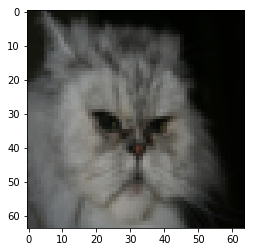

In [25]:
# 分类错误的示例
index = 12
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

可以看到模型对这张图片的分类正确，将猫图片分类为cat。

## 8 - 学习曲线

现在，根据之前保存的costs输出成本的变化情况

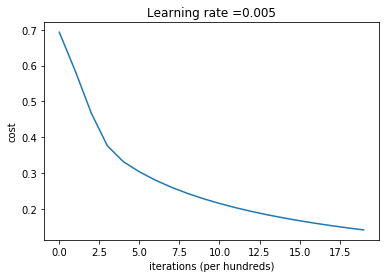

In [26]:
# 输出学习曲线
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()


可以看到，图中的成本随着迭代次数的增加而减小，这说明了参数w和b不断被学习和优化。

至此，Logistic回归模型的Python代码实现已经介绍完毕，相信读者对Logistic回归有了更深刻的理解和把握。